# 📖 Oral Cancer Screening – Two Stage Pipeline (MobileNetV3 + YOLOv8n)

## 🔹 0. Setup
Install dependencies and import required libraries.

In [ ]:
!pip install torch torchvision ultralytics matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

## 🔹 1. Mount Google Drive
We’ll use Google Drive to save models, metrics, plots, and inference outputs so they persist beyond the Colab session.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/OralCancer"
os.makedirs(BASE_DIR, exist_ok=True)

## 🔹 2. Dataset Paths
Define dataset paths (YOLO format already prepared) and CSV file for classification labels.

In [ ]:
images_dir = "/content/drive/MyDrive/Bootcamp/data/ORAL/images"
labels_dir = "/content/drive/MyDrive/Bootcamp/data/ORAL/labels"
csv_path = os.path.join(BASE_DIR, "normal_abnormal_labels.csv")
os.makedirs(os.path.join(BASE_DIR,"metrics"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR,"plots"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR,"inference_outputs"), exist_ok=True)

df = pd.read_csv(csv_path)

# Map string labels to integers
label_mapping = {"Normal": 0, "Abnormal": 1}
df['label'] = df['label'].map(label_mapping)

print("Dataset Overview:")

# # Identify splits from file paths
# df["split"] = df["image_path"].apply(lambda x: "train" if "/train/" in x else "val")

# # Replace relative paths with absolute paths
# df['image_path'] = df['image_path'].apply(lambda x: os.path.join(images_dir, os.path.basename(x)))

# print("Train size:", len(df[df["split"] == "train"]))
# print("Val size:", len(df[df["split"] == "val"]))
# print(df['label'].value_counts())
# df.head()

# Correct absolute path including train/val subfolders
df['image_path'] = df['image_path'].apply(lambda x: os.path.join("/content/drive/MyDrive/Bootcamp/data/ORAL/images",
                                                                 os.path.relpath(x, "data/ORAL/images")))
# Detect split (train vs val)
df["split"] = df["image_path"].apply(lambda x: "train" if "/train/" in x else "val")

print("Train size:", len(df[df["split"] == "train"]))
print("Val size:", len(df[df["split"] == "val"]))
df.head()

Dataset Overview:
Train size: 300
Val size: 300


,image_path,label,split
0,/content/drive/MyDrive/Bootcamp/data/ORAL/imag...,0,train
1,/content/drive/MyDrive/Bootcamp/data/ORAL/imag...,0,train
2,/content/drive/MyDrive/Bootcamp/data/ORAL/imag...,0,train
3,/content/drive/MyDrive/Bootcamp/data/ORAL/imag...,0,train
4,/content/drive/MyDrive/Bootcamp/data/ORAL/imag...,0,train


## 🔹 3. Stage 1 – MobileNetV3 Classification (Normal vs Abnormal

### 3.1 Data Preparation

In [ ]:
class OralCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        label = int(row["label"])  # ✅ make sure label is integer
        if self.transform:
            image = self.transform(image)
        return image, label

# ---- 3️⃣ Transforms ----
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ---- 4️⃣ Dataset objects ----
train_ds = OralCancerDataset(df[df.split=="train"], transform)
val_ds   = OralCancerDataset(df[df.split=="val"], transform)

# ---- 5️⃣ Collate function ----
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

# ---- 6️⃣ DataLoaders ----
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

Training samples: 300
Validation samples: 300


### 3.2 Model Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_ds)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss_total, val_correct = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_ds)
    val_losses.append(val_loss_total / len(val_loader))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Optional: Save checkpoint
    torch.save(model.state_dict(), os.path.join(BASE_DIR, f"mobilenetv3_epoch{epoch+1}.pth"))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Acc: 0.7400, Val Acc: 0.7567
Epoch 2/5, Train Acc: 0.8700, Val Acc: 0.8133
Epoch 3/5, Train Acc: 0.9633, Val Acc: 0.8433
Epoch 4/5, Train Acc: 0.9900, Val Acc: 0.8233
Epoch 5/5, Train Acc: 0.9867, Val Acc: 0.8267


### with early stopping

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5
train_losses, val_losses, val_accs = [], [], []

best_val_acc = 0.0  # Track best validation accuracy

for epoch in range(EPOCHS):
    # ---- Training ----
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_ds)
    train_losses.append(total_loss / len(train_loader))

    # ---- Validation ----
    model.eval()
    val_loss_total, val_correct = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_ds)
    val_losses.append(val_loss_total / len(val_loader))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # ---- Early Stopping: Save best model ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(BASE_DIR, "mobilenetv3_beste.pth"))
        print(f"Best model saved at epoch {epoch+1} with val acc: {val_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Acc: 0.7367, Val Acc: 0.7867
Best model saved at epoch 1 with val acc: 0.7867
Epoch 2/5, Train Acc: 0.9067, Val Acc: 0.8433
Best model saved at epoch 2 with val acc: 0.8433
Epoch 3/5, Train Acc: 0.9600, Val Acc: 0.8367
Epoch 4/5, Train Acc: 0.9800, Val Acc: 0.8300
Epoch 5/5, Train Acc: 0.9700, Val Acc: 0.8400


## Stage 2: YOLOv8 Detection for Abnormal Images

### Filter Abnormal Images

In [ ]:
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image

# Load the best MobileNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v3_small(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model.load_state_dict(torch.load(os.path.join(BASE_DIR, "mobilenetv3_beste.pth"), map_location=device))
model = model.to(device)
model.eval()

# Transform for MobileNet
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Filter abnormal images
abnormal_images = []
abnormal_labels = []

for idx, row in df.iterrows():
    img = Image.open(row["image_path"]).convert("RGB")
    img_tensor = val_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_tensor)
        label = torch.argmax(pred, dim=1).item()
    if label == 1:  # Abnormal
        abnormal_images.append(row["image_path"])
        abnormal_labels.append(row["label"])  # original label (if needed for YOLO)

print(f"Total abnormal images selected for YOLO training: {len(abnormal_images)}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total abnormal images selected for YOLO training: 535


### Prepare YOLO Dataset

In [ ]:
import os
from pathlib import Path
import shutil

# YOLO dataset structure
yolo_base = "/content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal"
os.makedirs(yolo_base, exist_ok=True)

for split in ["train", "val"]:
    os.makedirs(os.path.join(yolo_base, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_base, "labels", split), exist_ok=True)

# Copy abnormal images + labels to YOLO folder
for img_path in abnormal_images:
    # Decide split (train/val) from original df
    split = df[df.image_path == img_path]["split"].values[0]
    # Copy image
    shutil.copy(img_path, os.path.join(yolo_base, "images", split))
    # Copy corresponding YOLO label (txt)
    img_name = os.path.basename(img_path).replace(".jpg", ".txt")
    label_path = os.path.join(labels_dir, img_name)  # original YOLO label
    if os.path.exists(label_path):
        shutil.copy(label_path, os.path.join(yolo_base, "labels", split))

In [ ]:
import os
import shutil
import yaml

# Base paths
yolo_base = "/content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal"
images_dir = "/content/drive/MyDrive/Bootcamp/data/ORAL/images"
labels_dir = "/content/drive/MyDrive/Bootcamp/data/ORAL/labels"

# Make folders for YOLO dataset
for split in ["train", "val"]:
    os.makedirs(os.path.join(yolo_base, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_base, "labels", split), exist_ok=True)

# Copy images and labels
missing_labels = []
for img_path in df["image_path"]:
    split = df[df.image_path == img_path]["split"].values[0]  # 'train' or 'val'
    img_name = os.path.basename(img_path)
    label_name = img_name.replace(".jpg", ".txt")

    # Destination paths
    dst_img_path = os.path.join(yolo_base, "images", split, img_name)
    dst_label_path = os.path.join(yolo_base, "labels", split, label_name)

    # Copy image
    shutil.copy(img_path, dst_img_path)

    # Copy label (check correct train/val subfolder)
    src_label_path = os.path.join(labels_dir, split, label_name)
    if os.path.exists(src_label_path) and os.path.getsize(src_label_path) > 0:
        shutil.copy(src_label_path, dst_label_path)
    else:
        missing_labels.append(label_name)

if missing_labels:
    print(f"Warning: {len(missing_labels)} labels missing or empty. Examples: {missing_labels[:10]}")

# Create data.yaml for YOLO
data_yaml = {
    'path': yolo_base,
    'train': 'images/train',
    'val': 'images/val',
    'nc': 3,
    'names': ["Benign", "OPMD", "OCA"]
}

with open(os.path.join(yolo_base, "data.yaml"), "w") as f:
    yaml.dump(data_yaml, f)

print("YOLO abnormal dataset prepared successfully!")

YOLO abnormal dataset prepared successfully!


### Train YOLOv8 on Abnormal Images

In [ ]:
%%writefile /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/data.yaml
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images
val: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/labels

nc: 3
names: [Benign, OPMD, OCA]

Writing /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/data.yaml


In [ ]:
# Install YOLOv8 if not already installed
!pip install ultralytics --upgrade

from ultralytics import YOLO
import os

# Base directory (where your YOLO dataset and data.yaml are)
yolo_base = "/content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal"
data_yaml_path = os.path.join(yolo_base, "data.yaml")

# Project folder for YOLO runs
project_dir = os.path.join(yolo_base, "runs")
os.makedirs(project_dir, exist_ok=True)

# Create YOLOv8n model (nano, lightweight)
model_yolo = YOLO("yolov8n.pt")  # pretrained on COCO

# Train YOLO
results = model_yolo.train(
    data=data_yaml_path,
    epochs=50,
    batch=16,
    imgsz=640,
    project=project_dir,
    name="yolo_abnormal_stage2",
    exist_ok=True,
    save_period=5         # saves checkpoints every 5 epochs
)

# Export the best model to PyTorch format
best_model_path = os.path.join(project_dir, "yolo_abnormal_stage2", "weights", "best.pt")
export_path = os.path.join(yolo_base, "yolo_abnormal_best.pt")
model_yolo = YOLO(best_model_path)
model_yolo.export(format="pt", imgsz=640, save_dir=yolo_base)

print(f"YOLO training completed. Best model exported to: {export_path}")

Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_abnormal_stage2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: Fast image access ✅ (ping: 0.7±0.5 ms, read: 301.9±127.7 MB/s, size: 1623.5 KB)
train: Scanning /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/labels/train... 300 images, 0 backgrounds, 24 corrupt: 100% ━━━━━━━━━━━━ 300/300 3.6it/s 1:23
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-13-6-8.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-14-4-1.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-20-6-3.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-21-4-4.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-21-9-2.jpg: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/images/train/C-22-6-3.jpg: ignoring corrupt image/label: non-normalized or

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/50      2.13G      1.099      2.986      1.584         12        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 51.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.3s
                   all        281        637    0.00675       0.69      0.179      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/50      2.62G      1.061      2.396      1.548         29        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.1s
                   all        281        637     0.0303      0.666      0.191      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/50      2.66G      1.046      2.238      1.538         17        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 41.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.0s
                   all        281        637       0.23      0.217      0.162     0.0982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      2.66G      1.158      2.316      1.585         79        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/50      2.67G      1.099       2.16      1.532         21        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.1s
                   all        281        637      0.229      0.379      0.146     0.0905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      2.67G      1.033      2.053      1.489         96        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/50      2.69G      1.109      2.138      1.541         26        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.4it/s 25.6s
                   all        281        637      0.281      0.458      0.197      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/50       2.7G      1.098      2.075      1.531         31        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.2s
                   all        281        637      0.203      0.397      0.197     0.0989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/50      2.72G      1.036       1.98      1.471         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.9s
                   all        281        637      0.228      0.356        0.2      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      2.72G     0.9903      1.824      1.425         85        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/50      2.74G      1.012      1.956      1.442         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.6s
                   all        281        637      0.249      0.388      0.195      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      2.74G      1.063      2.019      1.538         89        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/50      2.76G       1.04       1.94      1.496         16        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.8s
                   all        281        637      0.345      0.359      0.233      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/50      2.77G      1.011      1.854      1.466         31        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.0s
                   all        281        637      0.296      0.486      0.228      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      2.77G      0.915      1.903      1.415         62        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/50      2.79G     0.9984       1.84      1.461         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.1s
                   all        281        637      0.301      0.432      0.254      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      2.79G     0.9008      1.716      1.419         67        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      2.81G     0.9707      1.806       1.43         13        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.5s
                   all        281        637      0.256      0.377      0.216      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      2.81G     0.9863      1.806      1.424         73        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/50      2.83G     0.9608      1.771      1.397         16        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 27.6s
                   all        281        637      0.363      0.376      0.263      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      2.83G     0.8561      1.667      1.325         94        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      2.84G     0.9441      1.727      1.408         28        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.5s
                   all        281        637      0.326      0.231      0.249      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      2.84G     0.8513      1.798      1.344         68        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/50      2.86G     0.9642      1.746      1.423         24        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.9s
                   all        281        637      0.303      0.445      0.288       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      2.86G     0.9838      1.597      1.426         77        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/50      2.87G     0.9213      1.665      1.367         18        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.7s
                   all        281        637      0.326      0.435      0.262      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      2.87G      0.943       1.56       1.34         88        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/50      2.89G     0.9312      1.621      1.377         14        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.4it/s 25.3s
                   all        281        637        0.3       0.51      0.272      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      2.89G     0.9722      1.539      1.499         63        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/50      2.91G     0.8967      1.611      1.372         24        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.2s
                   all        281        637      0.313      0.488      0.229      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      2.91G     0.7566       1.62      1.271         79        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/50      2.92G     0.8527      1.552      1.332         25        640: 100% ━━━━━━━━━━━━ 18/18 0.6it/s 31.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 28.6s
                   all        281        637      0.308      0.499      0.278      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      2.92G     0.9358      1.494      1.343         78        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/50      2.94G     0.8671      1.485      1.346         25        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.3s
                   all        281        637      0.266      0.466      0.254      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/50      2.96G     0.8521      1.535      1.346         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.4it/s 24.9s
                   all        281        637      0.327      0.479      0.294      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      2.96G     0.8703      1.468      1.361         80        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/50      2.98G      0.886      1.471      1.361         29        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 27.9s
                   all        281        637      0.356      0.435      0.302      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      2.98G     0.8677      1.398      1.364         74        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/50         3G     0.8227       1.42      1.318         13        640: 100% ━━━━━━━━━━━━ 18/18 0.6it/s 31.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.4it/s 25.5s
                   all        281        637      0.409      0.359      0.315      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50         3G     0.8345      1.535      1.292         70        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/50      3.01G     0.8237      1.405      1.294         20        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.2s
                   all        281        637      0.309      0.483      0.281      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      3.01G     0.7878      1.377      1.253         77        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/50      3.03G     0.8199       1.37      1.305         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.3s
                   all        281        637      0.417      0.364      0.324       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      3.03G     0.8327      1.527      1.357         65        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/50      3.04G     0.7925      1.335      1.295         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.4s
                   all        281        637       0.33      0.491      0.303      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      3.04G     0.7475      1.244      1.274         82        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/50      3.06G     0.8119       1.32       1.29         19        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.5s
                   all        281        637      0.392      0.438      0.307      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      3.06G     0.6567      1.252      1.204         71        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/50      3.08G     0.8082       1.35      1.308         28        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.8s
                   all        281        637      0.385      0.403      0.312      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      3.08G     0.8675      1.283      1.386         74        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/50       3.1G     0.8048      1.285      1.318          9        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.6s
                   all        281        637      0.345      0.457      0.301      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50       3.1G     0.8901      1.382      1.326         91        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/50      3.12G     0.7694      1.238      1.261         22        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 35.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.9s
                   all        281        637      0.475      0.363       0.35      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      3.12G      0.701      1.296      1.207         64        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      31/50      3.13G     0.7369      1.202      1.227         21        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.3s
                   all        281        637       0.45      0.381      0.345      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      3.13G     0.7606      1.053      1.236         79        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      32/50      3.15G     0.7403      1.195       1.25         10        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.4s
                   all        281        637      0.419      0.371      0.336      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      3.15G     0.6879      1.089      1.253         62        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      33/50      3.16G     0.7516      1.164      1.276         16        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 32.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.1s
                   all        281        637      0.356      0.451      0.299      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      3.16G     0.7402      1.164      1.272         67        640: 0% ──────────── 0/18  0.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      34/50      3.18G     0.7409      1.138       1.26         21        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.9s
                   all        281        637      0.368        0.4      0.334      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      3.18G      0.648      1.022      1.152         82        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      35/50       3.2G      0.699      1.075      1.215         18        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.2s
                   all        281        637      0.498      0.343      0.349      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50       3.2G     0.7447      1.029      1.266         77        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      36/50      3.22G     0.7109       1.06      1.206         16        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.7s
                   all        281        637      0.368      0.487      0.327      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      3.22G     0.7848      1.266      1.267         72        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      37/50      3.24G     0.6909       1.04      1.205         20        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 36.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.1s
                   all        281        637      0.387      0.469      0.345      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      3.24G     0.6325     0.8861       1.16         69        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      38/50      3.25G     0.7107      1.044      1.223         19        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 40.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.8s
                   all        281        637      0.514      0.367      0.376       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      39/50      3.27G     0.6647       1.01      1.201         16        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.4s
                   all        281        637      0.496      0.376      0.372      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      3.27G     0.7774      1.043      1.218         91        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      40/50      3.28G     0.6544      1.009      1.185         20        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 34.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 32.2s
                   all        281        637      0.474      0.344      0.364      0.293
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      3.28G     0.5602      1.061      1.123         31        640: 0% ──────────── 0/18  8.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      41/50       3.3G     0.6953      1.112      1.228          8        640: 100% ━━━━━━━━━━━━ 18/18 0.3it/s 59.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.8s
                   all        281        637      0.397      0.392      0.332      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50       3.3G     0.8199      1.095       1.36         39        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      42/50      3.32G     0.6755      1.057      1.232          8        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 42.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.5s
                   all        281        637      0.356      0.418      0.312      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      3.32G     0.7973      1.269      1.368         38        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      43/50      3.34G     0.6789     0.9858      1.243          7        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 46.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 32.7s
                   all        281        637       0.42      0.365      0.325      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      3.34G     0.6266     0.9323      1.185         30        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      44/50      3.35G     0.6535     0.9824      1.223          9        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 39.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 31.1s
                   all        281        637      0.509      0.372      0.355      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      3.35G     0.6745      1.008       1.19         37        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      45/50      3.37G     0.6499     0.9433       1.21         10        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 43.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.1s
                   all        281        637      0.489      0.393      0.357      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      3.37G     0.7012     0.8492      1.273         33        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      46/50      3.39G     0.6175     0.9413      1.201          8        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 43.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.6s
                   all        281        637       0.43      0.421      0.367      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      3.39G     0.5632     0.8014      1.156         29        640: 0% ──────────── 0/18  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      47/50      3.41G     0.6058     0.8389      1.165         14        640: 100% ━━━━━━━━━━━━ 18/18 0.4it/s 41.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 30.2s
                   all        281        637      0.495       0.39      0.342      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      3.41G     0.4385     0.6676      1.062         28        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      48/50      3.42G     0.5921     0.8063      1.139          7        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 38.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 26.1s
                   all        281        637      0.394      0.482      0.339      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      3.42G     0.5903     0.7473      1.172         29        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      49/50      3.44G     0.6032     0.7967       1.14          8        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 26.9s
                   all        281        637      0.461      0.404      0.343      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      3.44G     0.5013     0.7632      1.099         33        640: 0% ──────────── 0/18  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      50/50      3.46G     0.5636     0.7524      1.134          6        640: 100% ━━━━━━━━━━━━ 18/18 0.5it/s 37.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.3it/s 29.1s
                   all        281        637      0.395      0.426      0.344      0.281

50 epochs completed in 0.945 hours.
Optimizer stripped from /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2/weights/best.pt...
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━

ValueError: Invalid export format='pt'. Valid formats are ('torchscript', 'onnx', 'openvino', 'engine', 'coreml', 'saved_model', 'pb', 'tflite', 'edgetpu', 'tfjs', 'paddle', 'mnn', 'ncnn', 'imx', 'rknn')

### Visualization of metrics

Showing results.png...


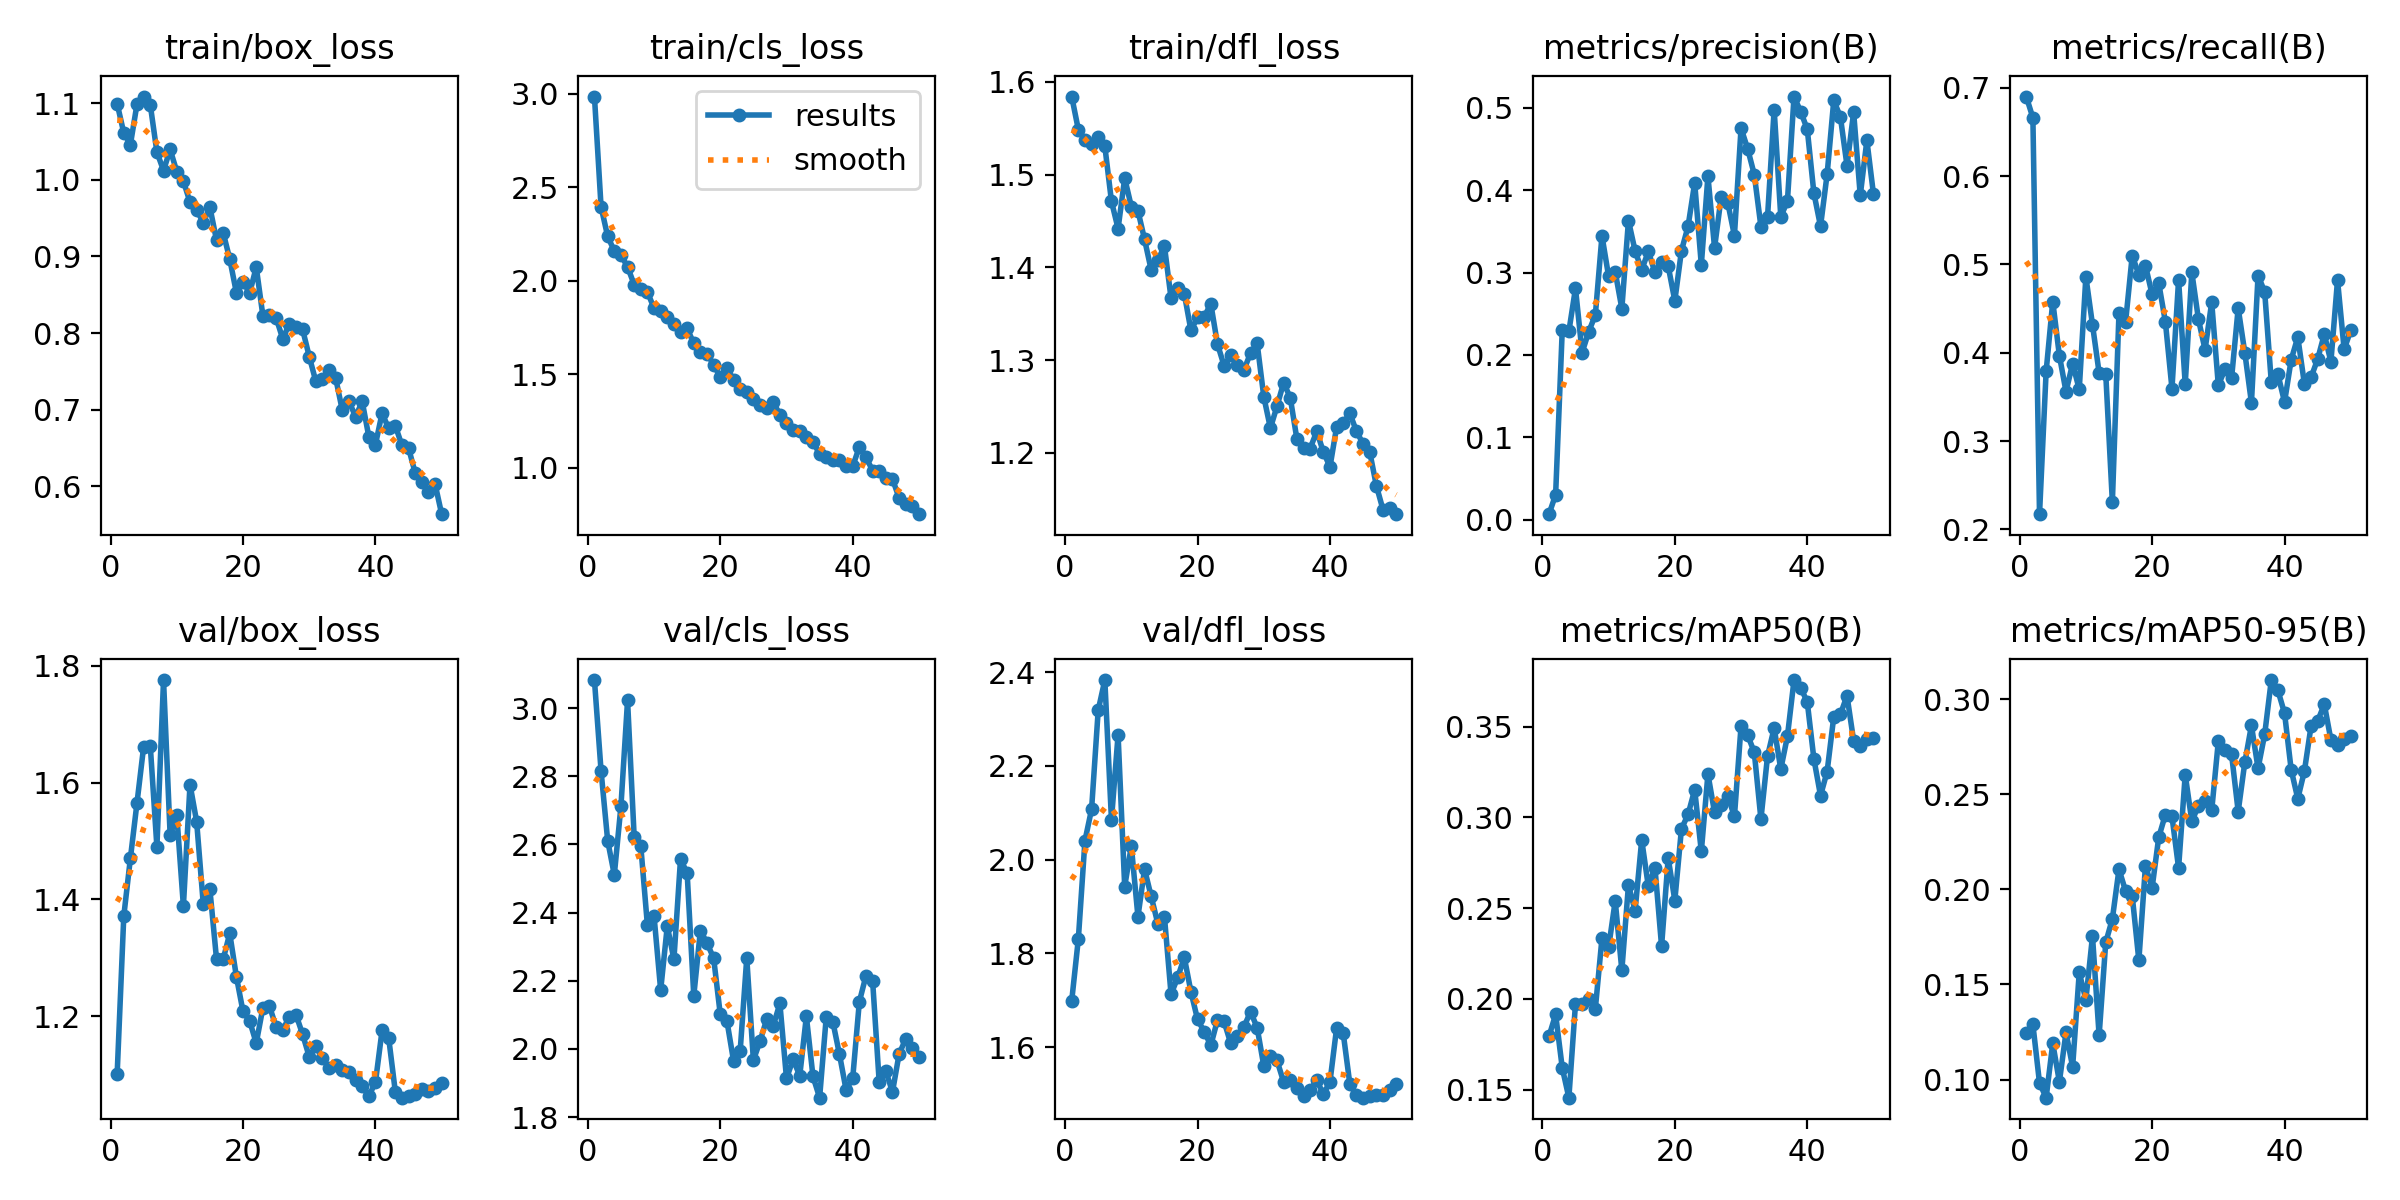

PR_curve.png not found in /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2
F1_curve.png not found in /content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2
Showing confusion_matrix.png...


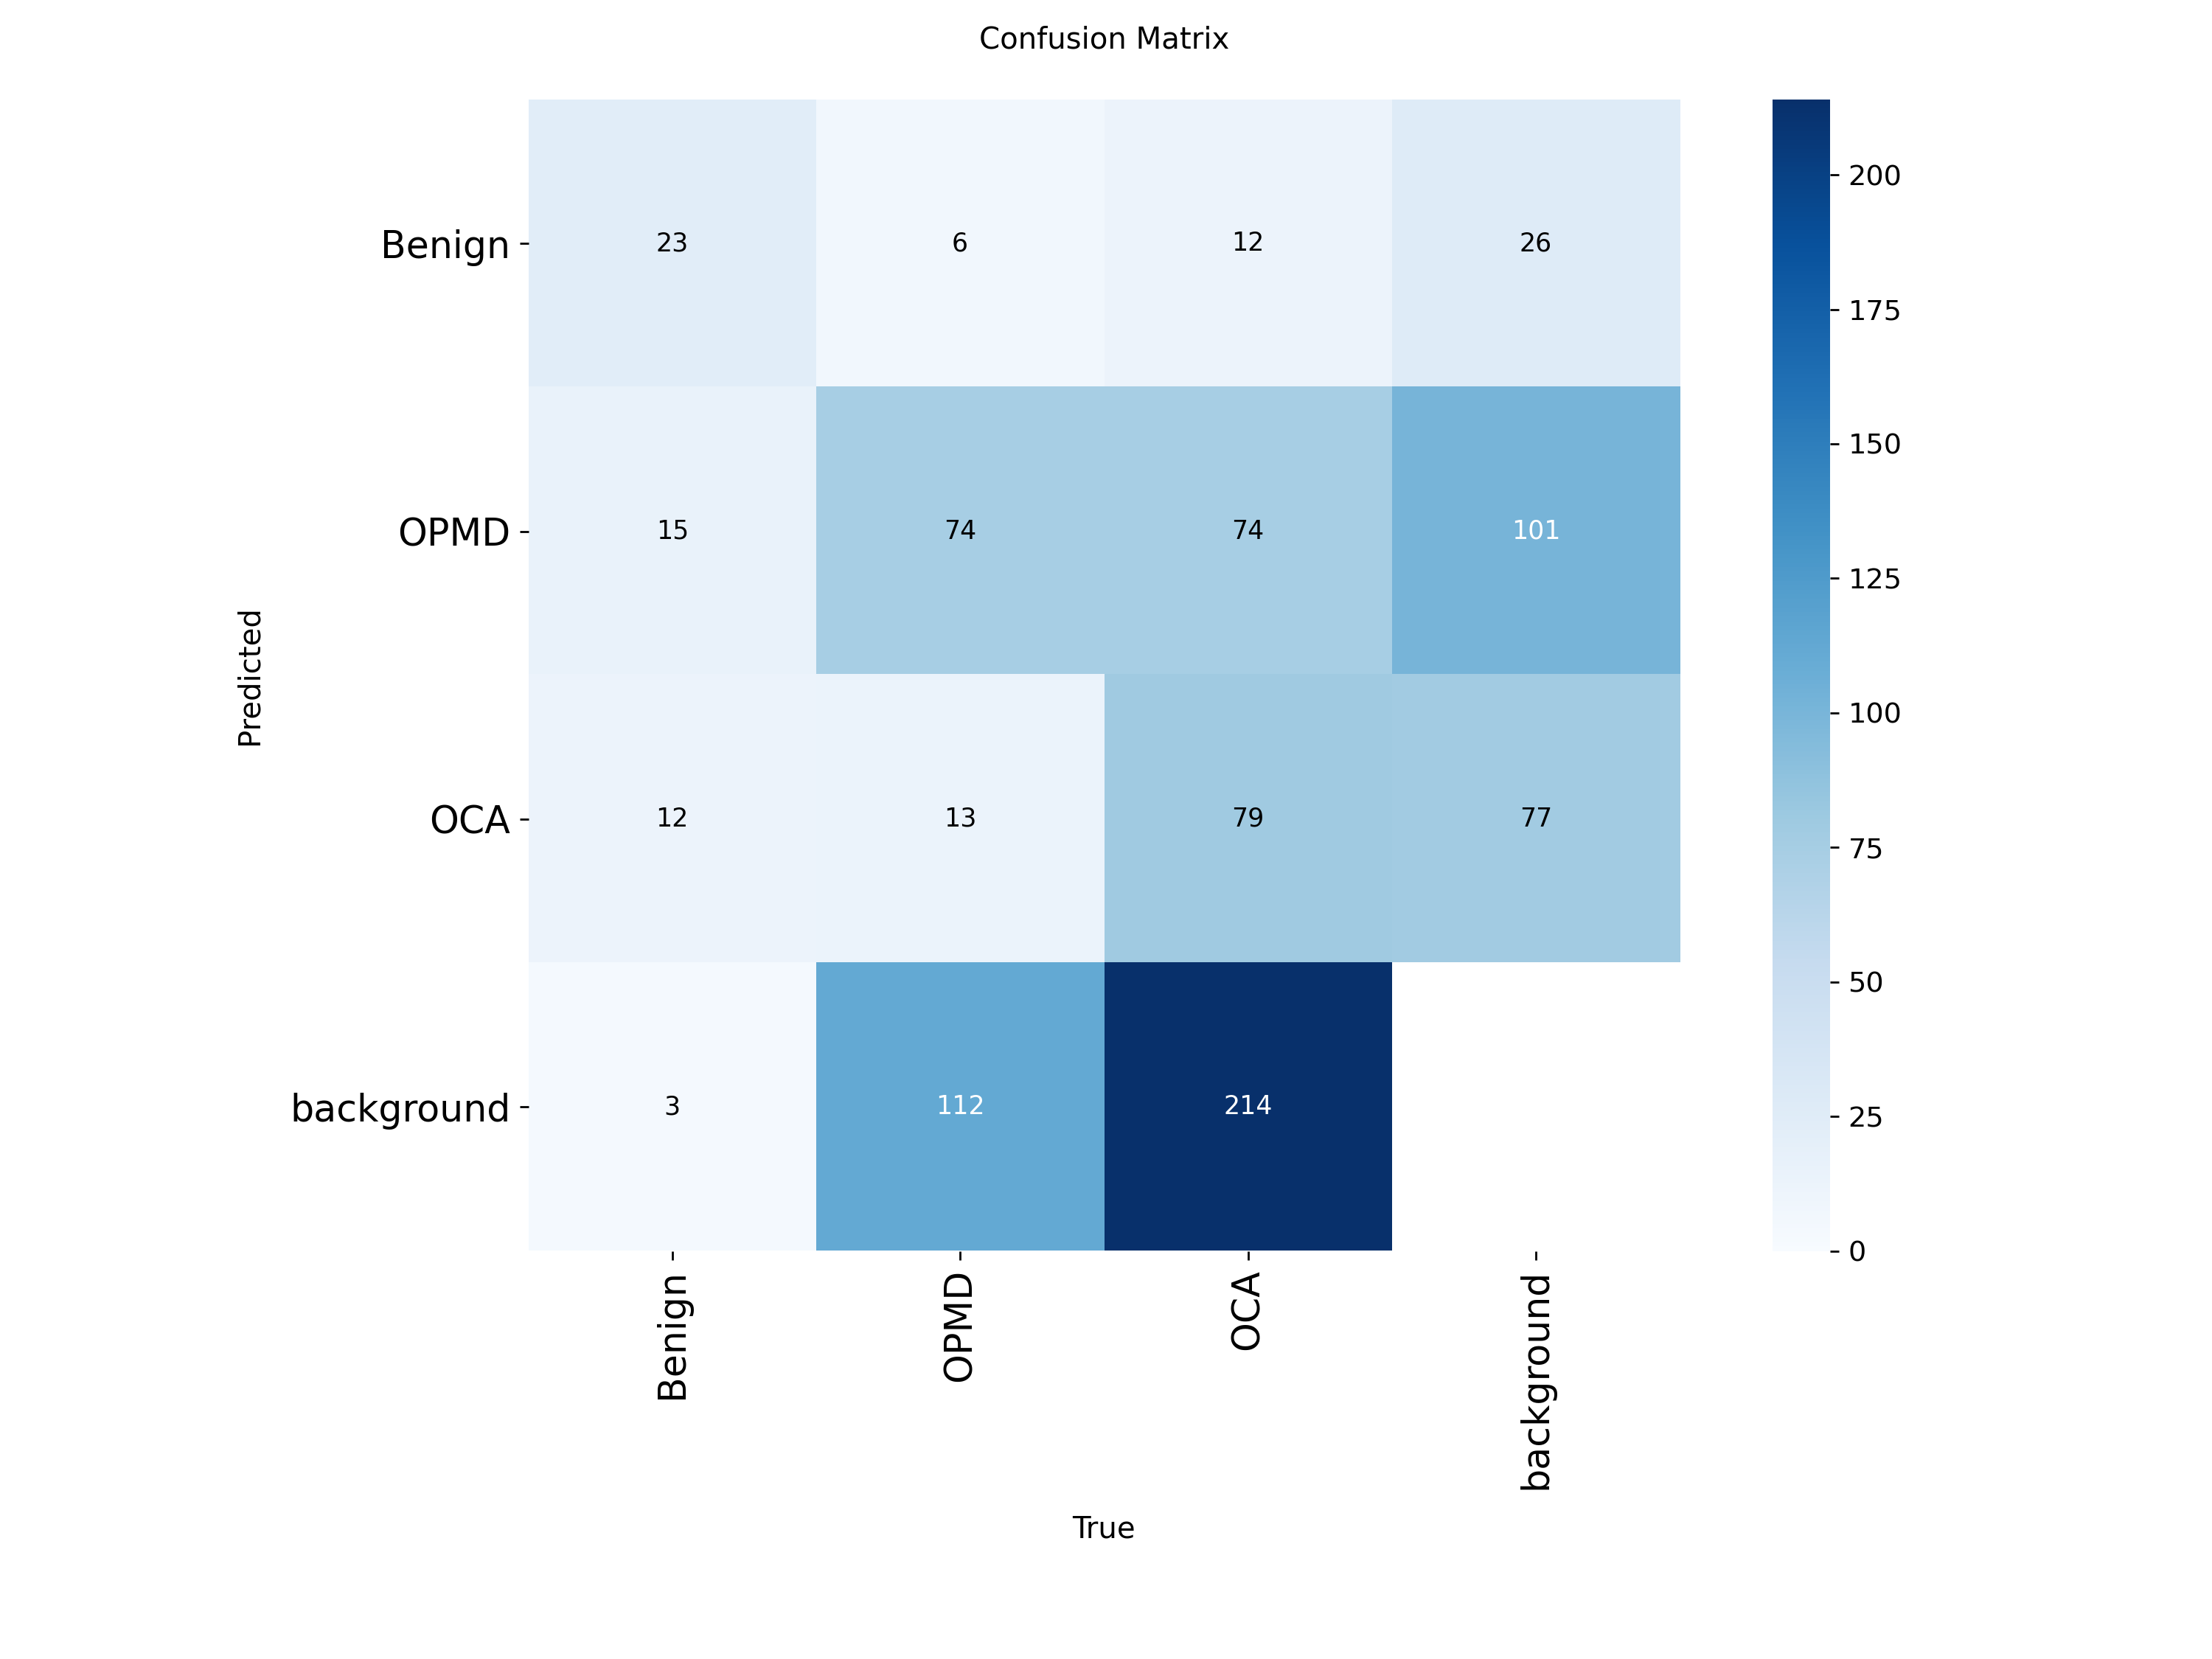

Showing val_batch0_pred.jpg...


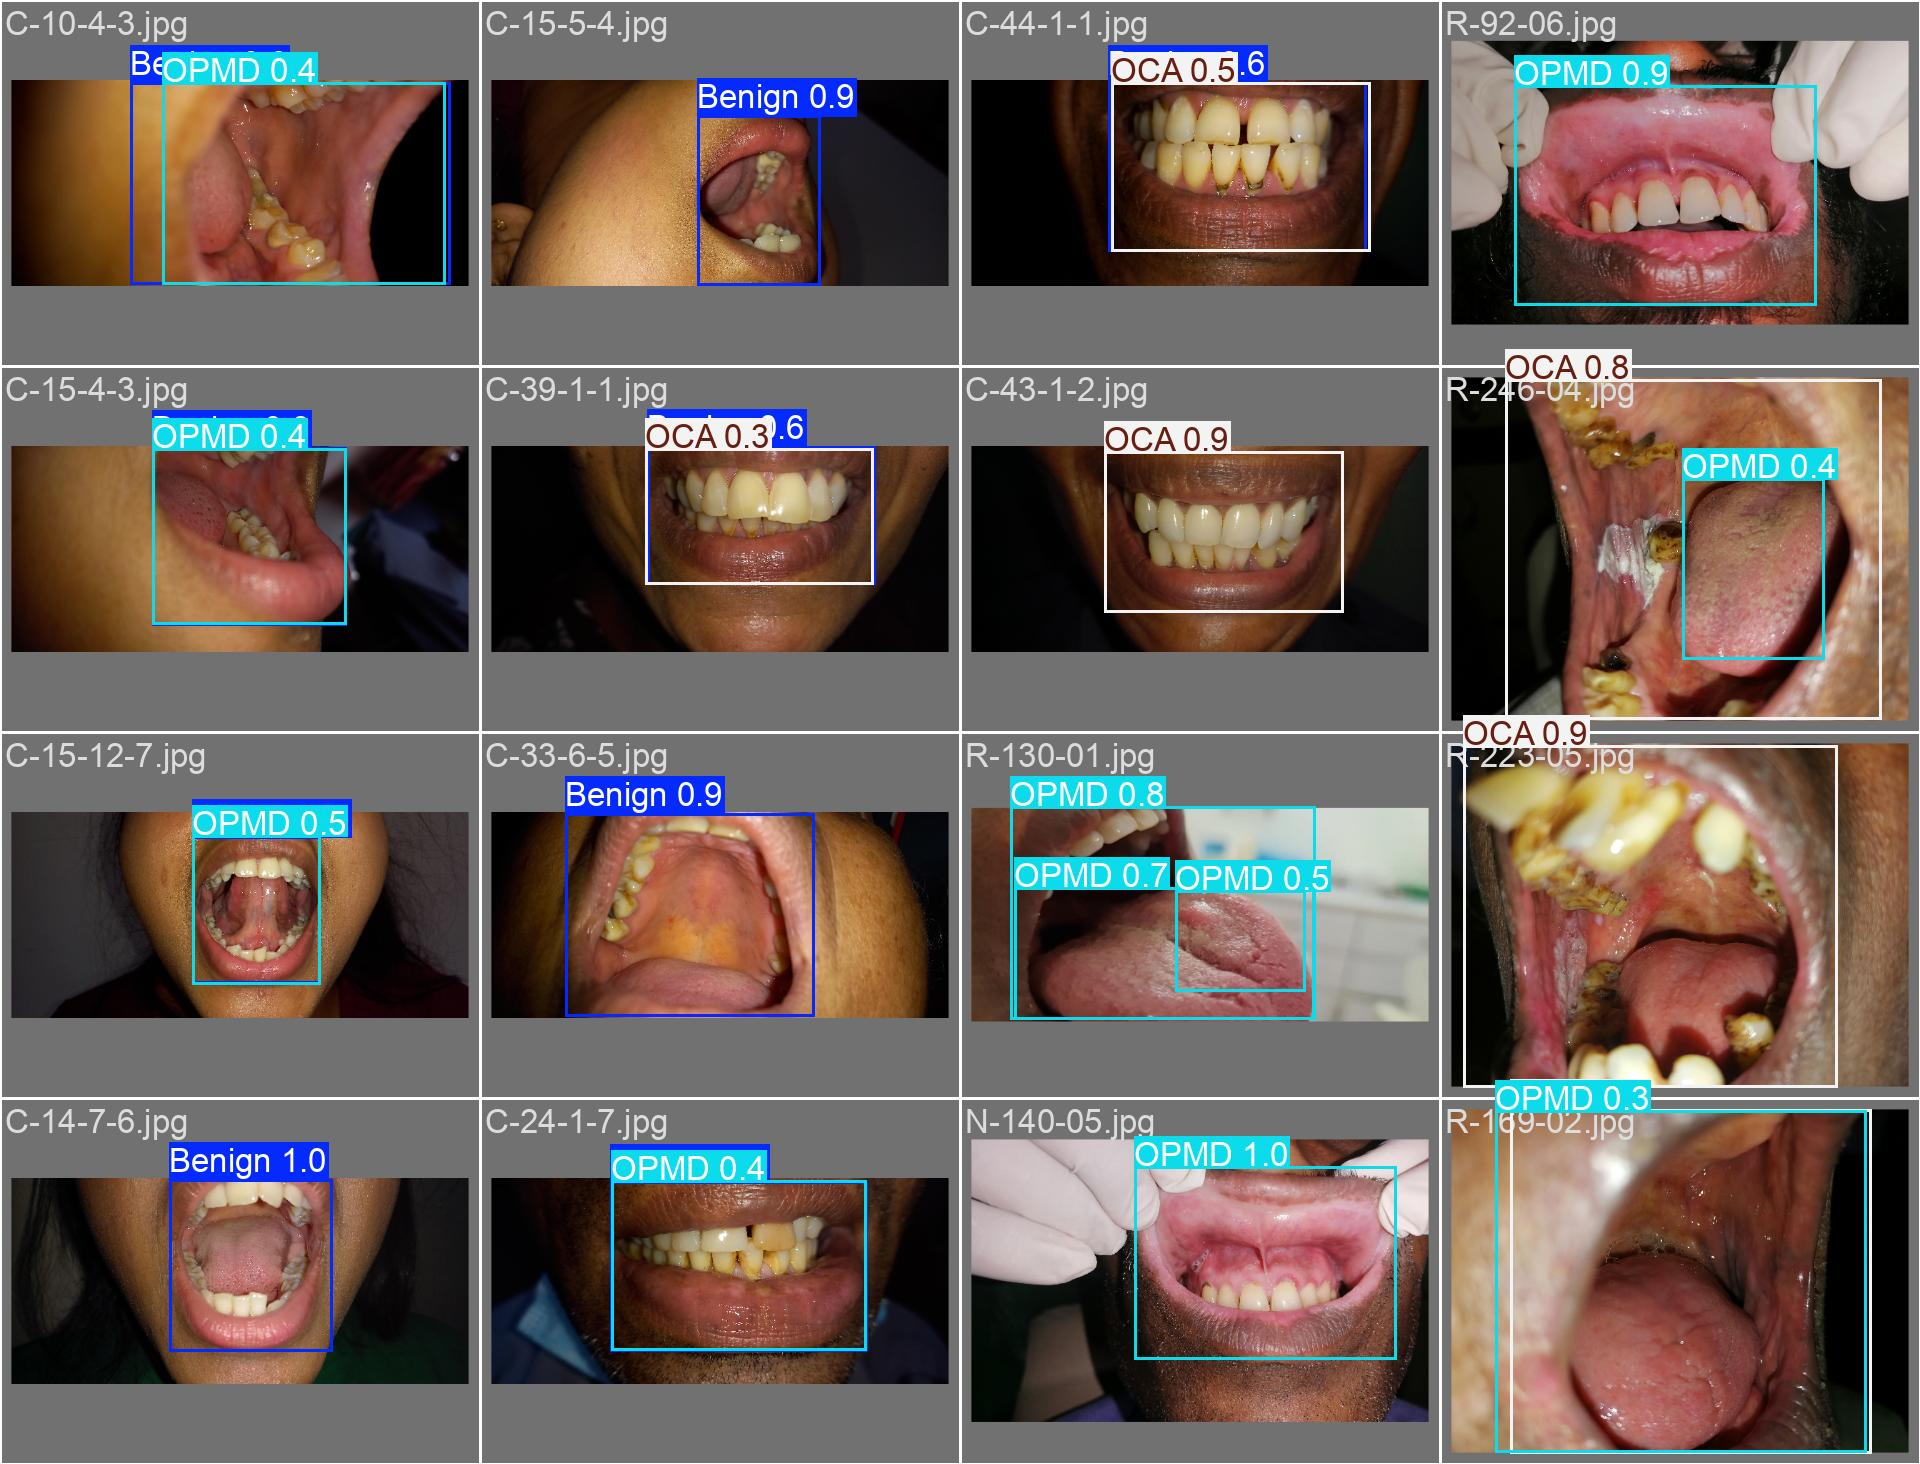

Showing val_batch1_pred.jpg...


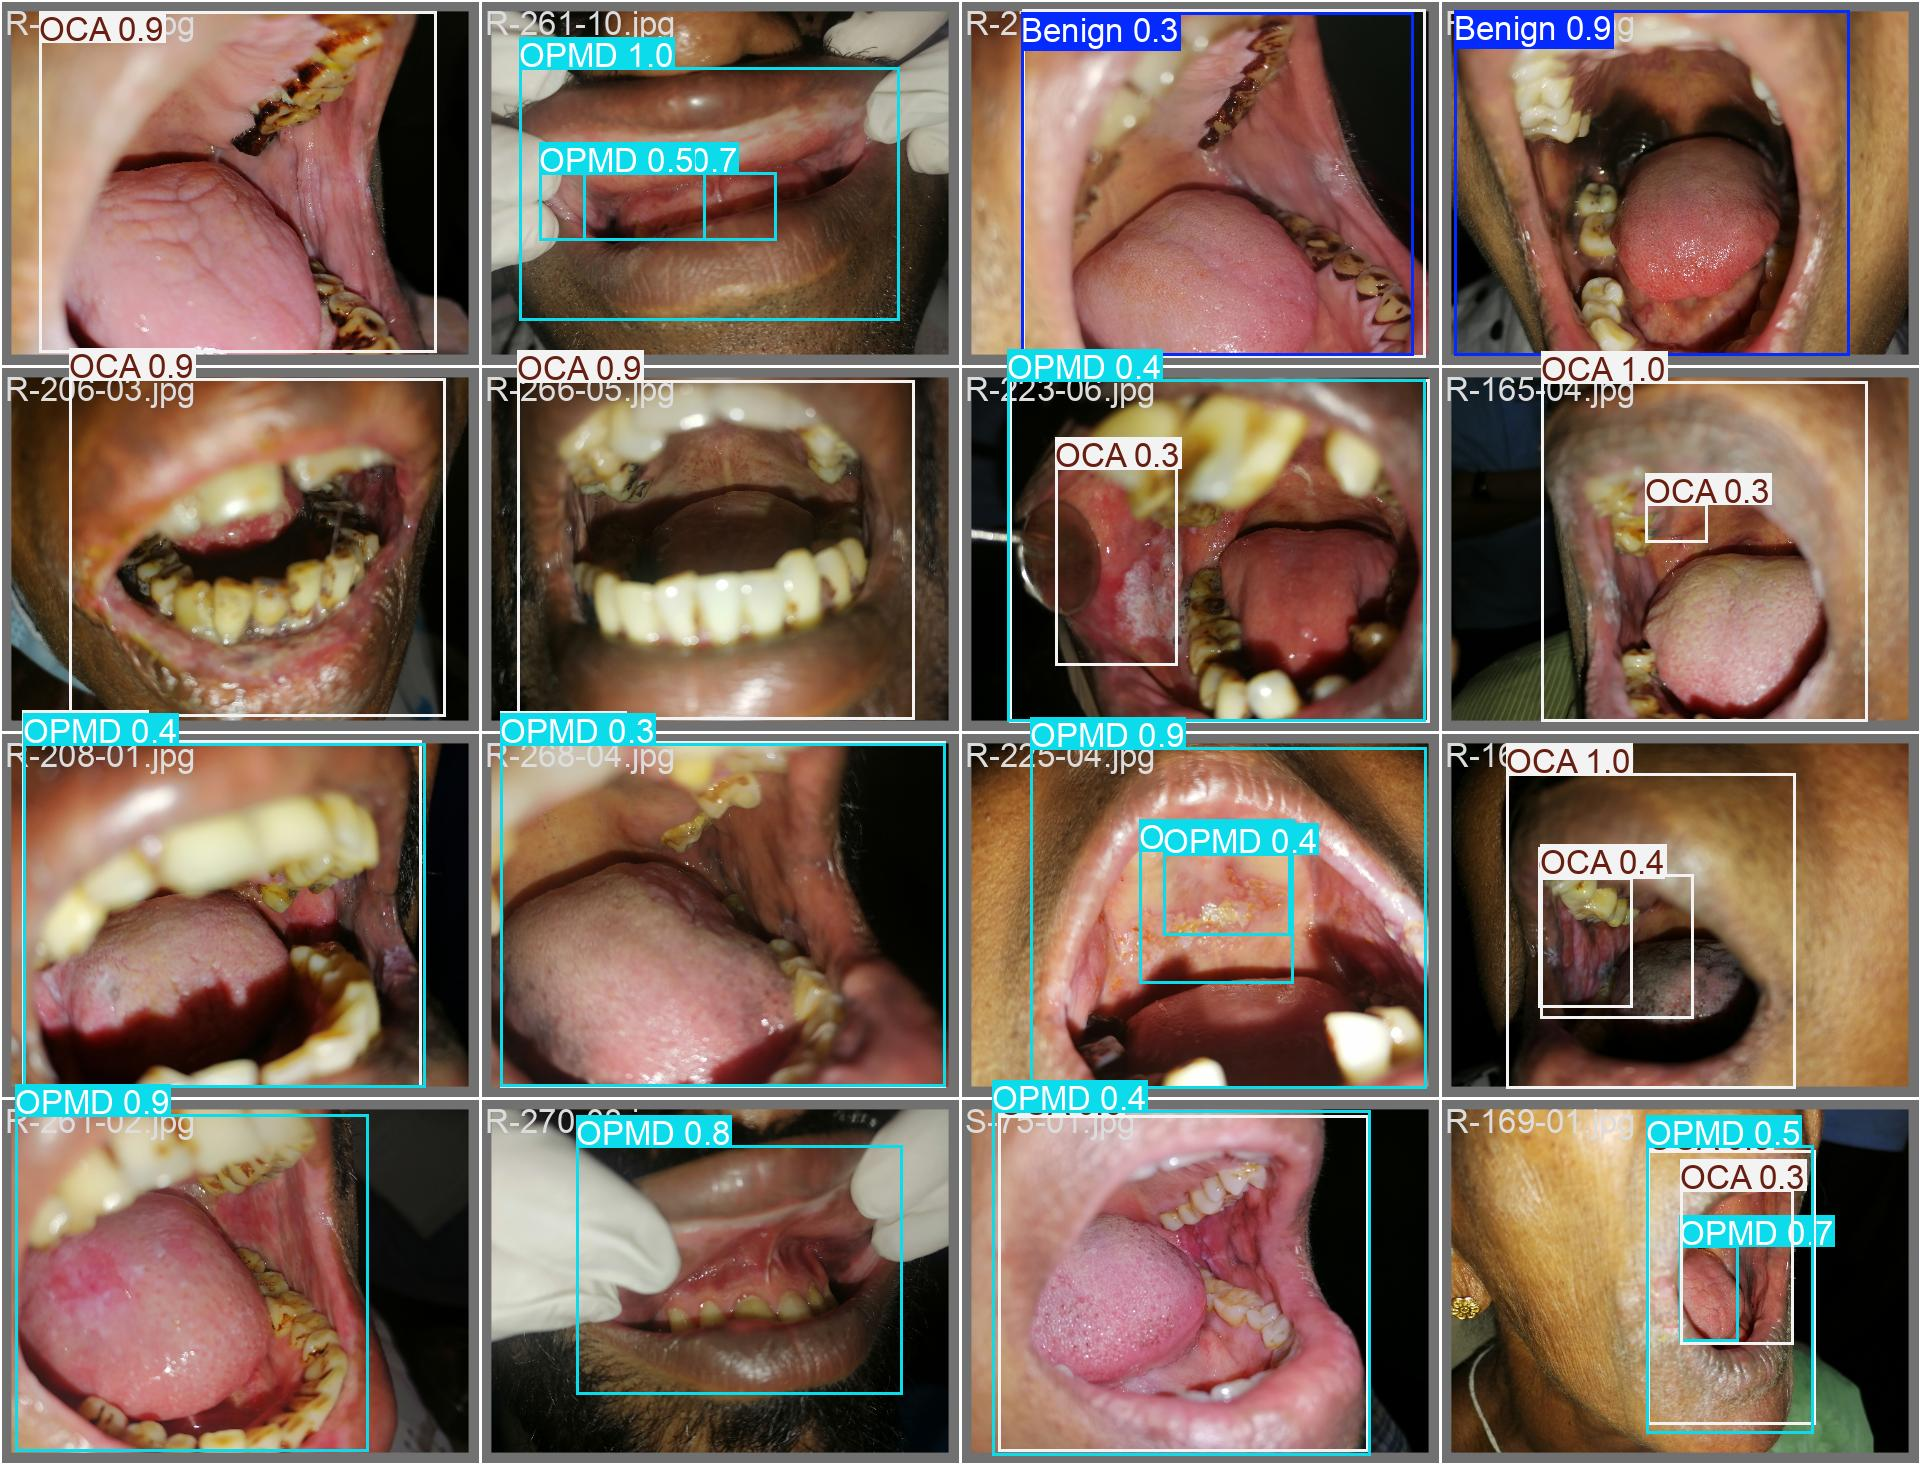

Showing val_batch2_pred.jpg...


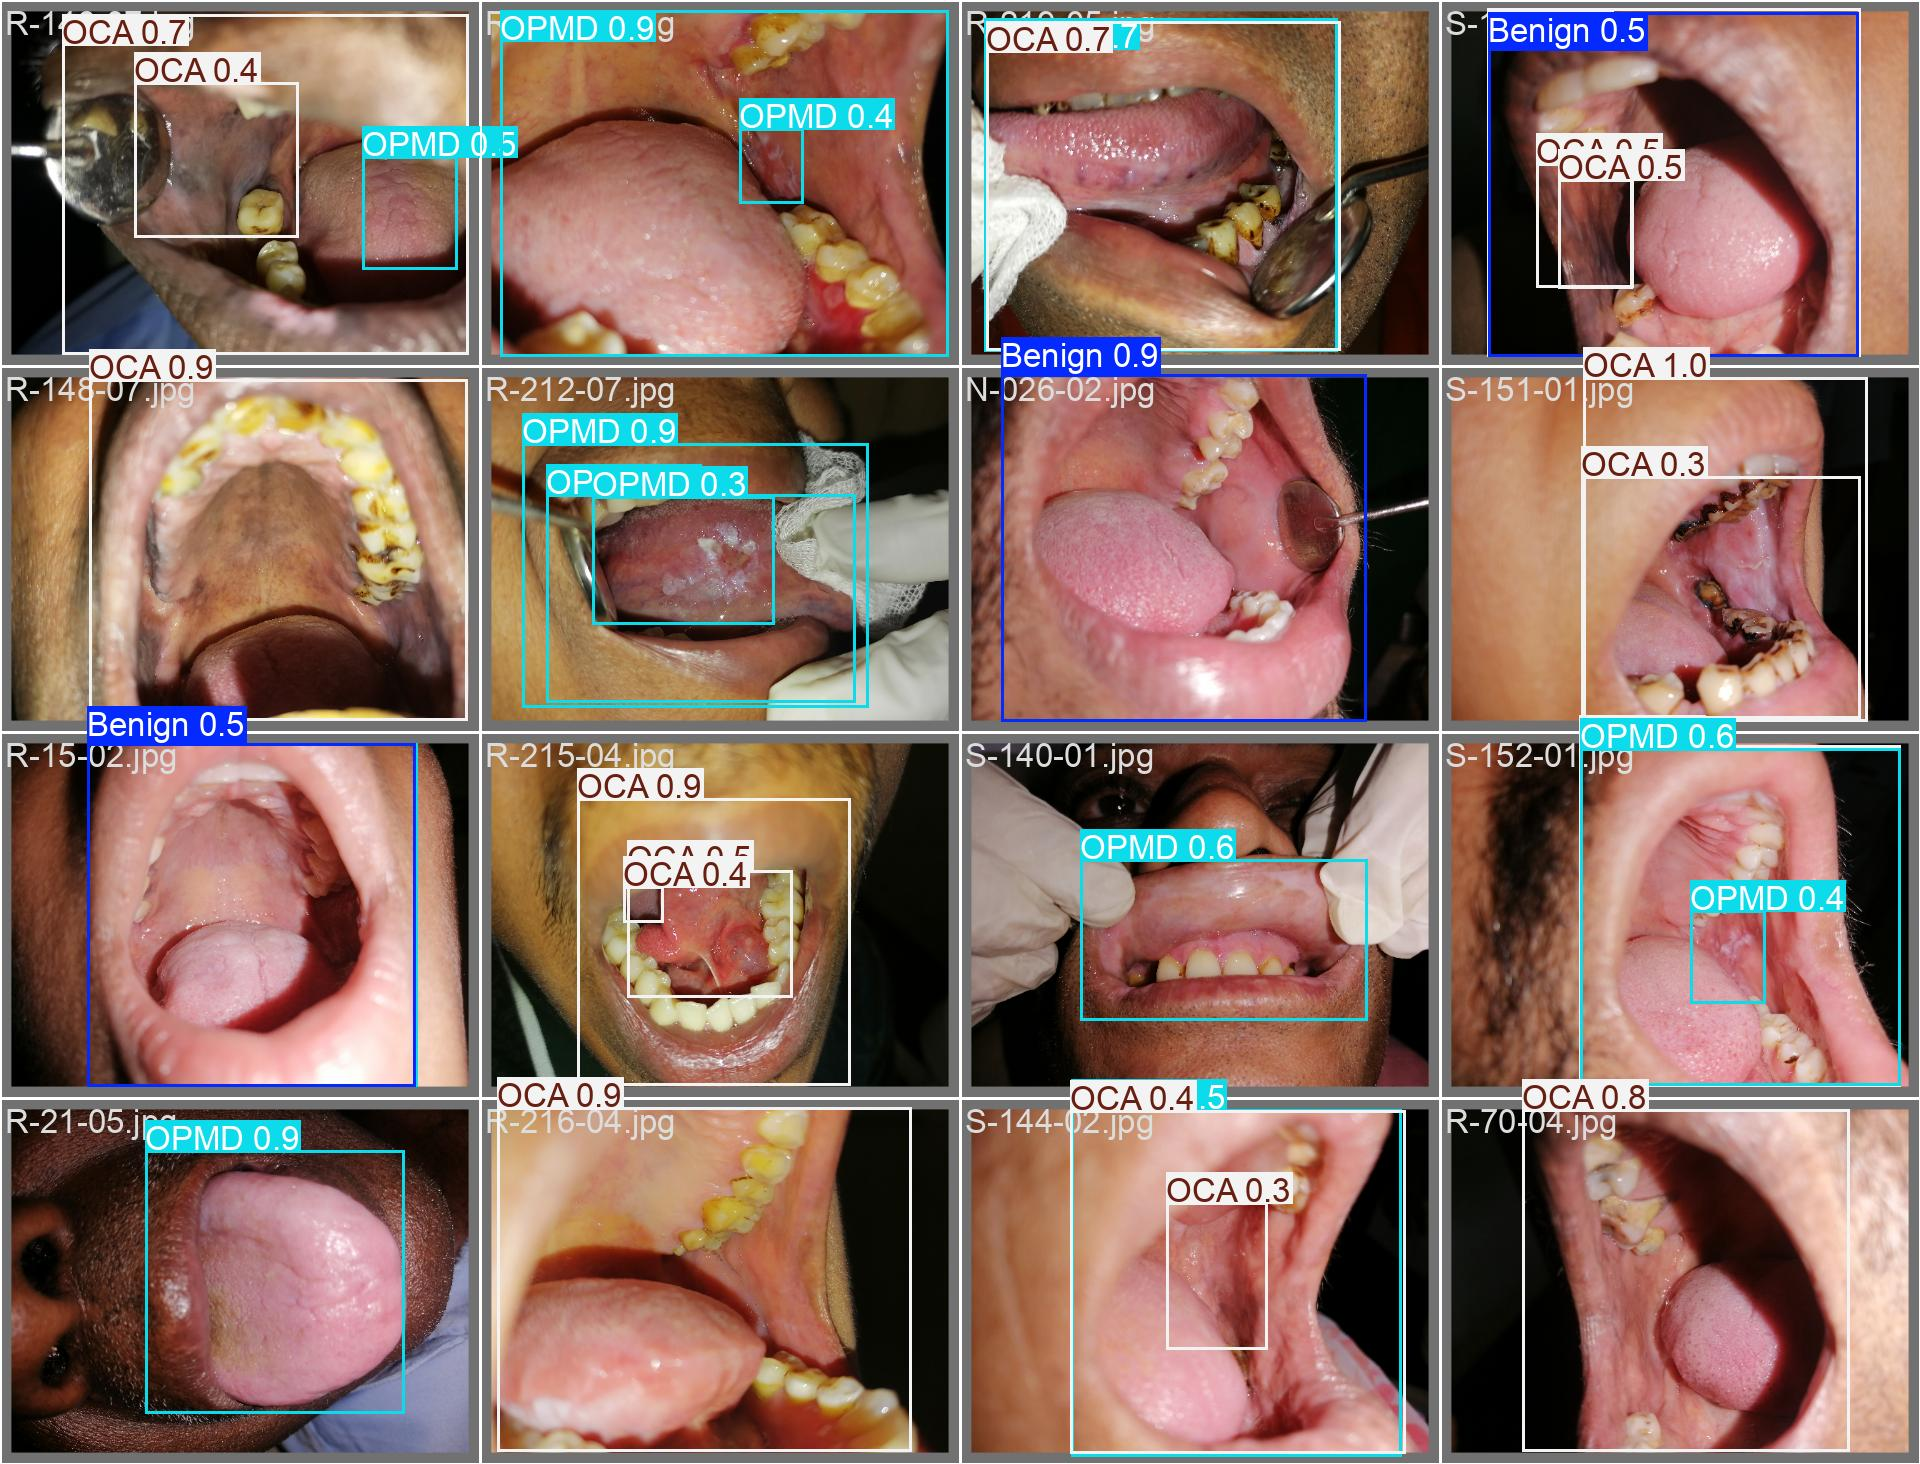

In [ ]:
import os
from IPython.display import Image, display

# Path where YOLO saved your training outputs
run_dir = "/content/drive/MyDrive/Bootcamp/data/ORAL/YOLO_Abnormal/runs/yolo_abnormal_stage2"

# Common result plots YOLO produces
plots = [
    "results.png",             # training & validation curves
    "PR_curve.png",            # precision-recall curve
    "F1_curve.png",            # F1-score curve
    "confusion_matrix.png",    # confusion matrix
    "val_batch0_pred.jpg",     # sample predictions on validation set
    "val_batch1_pred.jpg",
    "val_batch2_pred.jpg"
]

for plot in plots:
    plot_path = os.path.join(run_dir, plot)
    if os.path.exists(plot_path):
        print(f"Showing {plot}...")
        display(Image(filename=plot_path))
    else:
        print(f"{plot} not found in {run_dir}")